In [1]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ejecutar esta línea si pymoo no ha sido instalado
# %pip install -U pymoo

### Parámetros
Información que obtiene el modelo del sistema de información

In [2]:
# Demanda
DEMANDA = 60
# Costo por unidad de tiempo
CTIEMPO = 100
# Tiempo máximo definido
T_MAX = 360
# Parámetros de entrada
params_df = pd.read_excel('./data/' + 'nuevo_info_acopios.xlsx')
# Matriz de costos de transporte
trans_cost_df = pd.read_excel('./data/' + 'costoTransporteCAi.xlsx', index_col=0)
# Matriz de tiempos de transporte
trans_time_df = pd.read_excel('./data/' + 'tiempoTransporteCAi.xlsx', index_col=0)

### Variables
Definición de variables para el modelo

In [3]:
# Número de centros de acopio
N = params_df.shape[0]

# Vector de representación
CAPACIDADES = np.empty(N*2, dtype=float)

# Capacidades en stock y potencial por centro de acopio
for cap_i in range(0, N*2, 2):
    CAPACIDADES[cap_i] = params_df['Stock'].iloc[cap_i//2]
    CAPACIDADES[cap_i+1] = params_df['Ppotencial'].iloc[cap_i//2]
    
CAPACIDADES = np.append(CAPACIDADES, N-1)

### Parámetros

Para las operaciones de optimización

In [4]:
seed=1

# parámetros de SA y GA

# Función objetivo
$$
\begin{align*}
    \sum_{i=1 \quad i\neq p}^{N} &\big[ \, kCA_i \times Precio(CA_i) + cTransp(CA_i) + Tiempo(CA_i) \times cTiempo \, \big] \, + \\
                                 &\big[ \, kCA_p \times Precio(CA_p) + cTransp(CA_p) + Tiempo(CA_p) \times cTiempo \, \big]
\end{align*}
$$

Sujeta a las restricciones:
$$
\begin{align*}
    \sum_{i=0}^{N} kCA_i &= Demanda \\
    kCA_i &\leq Stock(CA_i) + Ppotencial(CA_i) &\therefore \, i=0,\cdots ,N \\
    TiempoAlistam(CA_i) &\leq TiempoMaxDefinido &\therefore \, i=0,\cdots ,N \\
    Tiempo(CA_i) &= TiempoAlistam(CA_i) + TiempoTransp(CA_i) \\
\end{align*}
$$

In [5]:
def get_delta(x, i, idx_acopio, idx_principal=-1):
    kca = x[i] + x[i + 1]
    precio = params_df['Precio'].iloc[idx_acopio]
    talistam = 0

    if x[i + 1]:
        talistam = params_df['TiempoAlistam'].iloc[idx_acopio]

    ' Si es el centro de acopio principal (idx_principal=-1) '
    if idx_principal < 0:
        ctransp = params_df['Ctransp'].iloc[idx_acopio]
        ttransp = params_df['TiempoTransp'].iloc[idx_acopio]
        tiempo = talistam + ttransp

        return (kca * precio) + ctransp + (tiempo * CTIEMPO)
    else:
        ctransp = trans_cost_df.iloc[idx_acopio, idx_principal]
        ttransp = trans_time_df.iloc[idx_acopio, idx_principal]
        tiempo = talistam + ttransp

        return (kca * precio) + ctransp + (tiempo * CTIEMPO)

In [6]:
def f(x):
    delta = 0
    idx_principal = int(x[N*2])

    for i in range(0, N*2, 2):
        idx_acopio = i//2

        if x[i] == 0 and x[i+1] == 0:
            continue

        if idx_acopio == idx_principal:
            # Única suma de kCAp
            delta += get_delta(x, i, idx_acopio)
            continue
            
        # Sumas con kCAi
        delta += get_delta(x, i, idx_acopio, idx_principal)

    return delta

Función que altera el vector para que cumpla con la restricción de igualdad

In [7]:
def balance(individual, delta, diff):
    delta = np.squeeze(delta)
    
    # Reducir para igualar a la demanda
    if diff:
        acopios = list(np.nonzero(individual)[0])

        while delta > 0 and len(acopios) > 0:
            idx = np.random.choice(acopios)
            acopios.remove(idx)

            if delta <= individual[idx]:
                individual[idx] -= delta
                delta = 0
            else:
                delta -= individual[idx]
                individual[idx] = 0
    # Aumentar para igualar a la demanda
    else:
        acopios = list(np.where(individual == 0)[0])

        while delta > 0 and len(acopios) > 0:
            idx = np.random.choice(acopios)
            acopios.remove(idx)

            if delta <= CAPACIDADES[idx]:
                individual[idx] = delta
                delta = 0
            else:
                individual[idx] = CAPACIDADES[idx]
                delta -= CAPACIDADES[idx]

Función para mostrar la cantidad asignada y la total por centro de acopio

In [8]:
def print_acopios(X):
    for i in range(0, N*2, 2):
        idx_ca = i // 2
        print(f'Centro de acopio {params_df['Id_CA'].iloc[idx_ca]}:')
        print(f'Stock: {params_df['Stock'].iloc[idx_ca]}, \t\t\tAsignado: {X[i]}')
        print(f'Potencial: {params_df['Ppotencial'].iloc[idx_ca]}, \tAsignado: {X[i+1]}\n')
        

# Enfriamiento Simulado

## Generación
De nuevas posibles soluciones

In [9]:
def gen_s0(n_vars):
    # Se indexan los centros de acopio
    gen_vector = np.zeros(n_vars+1, dtype=float)

    # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
    indices = np.arange(n_vars)
    np.random.shuffle(indices)

    while np.sum(gen_vector) < DEMANDA and indices.size > 0:
        idx = indices[0]
        gen_vector[idx] += CAPACIDADES[idx]
        indices = np.delete(indices, 0)

        if np.sum(gen_vector) > DEMANDA:
            gen_vector[idx] = gen_vector[idx] - (np.sum(gen_vector) - DEMANDA)
            break

    gen_vector[n_vars] = np.random.randint(CAPACIDADES[n_vars] + 1)

    return gen_vector

In [10]:
# def gen_s(self, problem, X):
#     for i in range(len(X)):
#         r = np.random.random()
# 
#         if r < self.prob:
#             # Se toma un índice aleatorio
#             individual = X[i]
#             idx_mut = np.random.randint(individual.shape)
# 
#             # Si es el índice del centro de acopio principal (N*2)
#             if idx_mut == N*2:
#                 X[i, problem.n_var-1] = np.random.randint(CAPACIDADES[N*2] + 1)
# 
#             else:
#                 if individual[idx_mut] == 0:
#                     # Se asigna la máxima cantidad posible del índice
#                     delta = CAPACIDADES[idx_mut]
#                     individual[idx_mut] = CAPACIDADES[idx_mut]
#                     diff = True
#                 else:
#                     # Se asigna cero a la cantidad del índice
#                     delta = individual[idx_mut]
#                     individual[idx_mut] = 0
#                     diff = False
# 
#                 balance(individual, delta, diff)
# 
#                 for j in range(individual.shape[0]):
#                     X[i, j] = individual[j]
# 
#     return X

- $ \textit{Sea } x = x_0 $
- $ \textit{Mientras } t > t_{min}, e > e_{th}: $ 
- $ \qquad \text{Generar una nueva solución aleatoria, } x_{new} \leftarrow gen(x) $ 
- $ \qquad \textit{Si } P(f(x), f(x_{new}), t) \geq rand(0, 1): \\$ 
- $ \qquad \qquad \textit{entonces } x \leftarrow x_{new} $
- $ \text{Salida: } x_{final}$

In [11]:
def anneal(temp, t_min, e_th, alpha):
    size = CAPACIDADES.shape[0] - 1
    x = gen_s0(size)
    e = f(x)
    n = 0

    while temp > t_min and e > e_th:
        x_new = gen_s0(size)
        e_new = f(x_new)

        delta = e_new - e

        if delta < 0:
            x = x_new
            e = e_new
        else:
            asd = -delta / temp
            p = np.exp(asd)
            r = np.random.rand()

            if r < p:
                x = x_new
                e = e_new

        temp *= alpha
        n += 1

    return x, n


def sa(t_max, t_min, e_th, alpha, seed=1):
    np.random.seed(seed)
    x, count = anneal(t_max, t_min, e_th, alpha)
    print(f'Count: ', count)
    return x


## Aplicación

In [12]:
' Enfriamiento simulado '

# Temperatura inicial
max_anneal = 1e4
# Temperatura final de enfriamiento (terminación)
min_anneal = 1e-9
# Energía mínima (terminación)
energy = 1e-6
# Ratio de enfriamiento
r_anneal = 0.995

In [13]:
t_start_sa = timeit.default_timer()
sa = sa(max_anneal, min_anneal, energy, r_anneal)
t_end_sa = timeit.default_timer()

t_delta_sa = t_end_sa - t_start_sa
sa

Count:  5972


array([10. ,  0. , 12. ,  0. ,  0. ,  0. ,  8. , 13. ,  0. ,  0. ,  0. ,
        0. ,  4.5,  0. ,  0. , 12.5,  0. ,  0. ,  0. ,  0. ,  5. ])

In [14]:
# print_acopios(sa)
print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(sa[N*2])]}')
print(f'Precio: {f(sa)}')
print(f'Tiempo: {round(t_delta_sa * 1000)}ms, ({t_delta_sa})')

Centro de acopio principal: CA6
Precio: 437103.0
Tiempo: 3062ms, (3.0623979999218136)


# Algoritmo Genético (pymoo)

Definición del modelo de optimización

In [15]:
from pymoo.core.problem import ElementwiseProblem

xl = np.zeros(CAPACIDADES.shape[0])
xu = CAPACIDADES

class Queso(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=len(xl),
            n_obj=1,
            n_eq_constr=1,
            # n_ieq_constr=1,
            xl=xl,
            xu=xu
        )


    def _evaluate(self, x, out, *args, **kwargs):
        out['F'] = f(x)
        # Se retira el último elemento del vector (centro de acopio principal), 
        # para validar la restricción de igualdad
        individual = np.delete(x, N*2)
        out['H'] = DEMANDA - np.sum(individual)

model = Queso()

## Generación 
De nuevas posibles soluciones

In [16]:
from pymoo.core.sampling import Sampling

class TopOrZeroSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        gen_matrix = np.zeros((n_samples, problem.n_var), dtype=float)
        # Se indexan los centros de acopio
        n_vars = problem.n_var

        for i in range(n_samples):
            # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
            indices = np.arange(n_vars-1)
            np.random.shuffle(indices)

            while np.sum(gen_matrix[i]) < DEMANDA and indices.size > 0:
                idx = indices[0]
                gen_matrix[i, idx] += CAPACIDADES[idx]
                indices = np.delete(indices, 0)

                if np.sum(gen_matrix[i]) > DEMANDA:
                    gen_matrix[i, idx] = gen_matrix[i, idx] - (np.sum(gen_matrix[i]) - DEMANDA)
                    break

            gen_matrix[i, N*2] = np.random.randint(CAPACIDADES[N*2] + 1)

        return gen_matrix

## Cruce

Implementación de cruce en un punto

In [17]:
from pymoo.core.crossover import Crossover

class SinglePointCross(Crossover):
    def __init__(self, prob): 
        # Para la implementación personalizada de este método, se consideraron 2 padres,
        # entonces cambiar los valores de la llamada a init no tendrá efecto.
        # Lo mismo pasa con el único offspring.
        super().__init__(n_parents=2, n_offsprings=1, prob=prob)

    def _do(self, problem, X, **kwargs):
        # n_parents, n_matings, n_var
        _, n_matings, n_var = X.shape

        T = np.zeros((1, n_matings, n_var))
        Y = np.full_like(T, None, dtype=float)

        for idx in range(n_matings):

            # Primera mitad
            p1 = X[0, idx, : n_var//2]
            # Segunda mitad
            p2 = X[1, idx, n_var//2 : n_var - 1]

            offspring = np.concatenate((p1, p2))

            if np.sum(offspring) > DEMANDA:
                delta = np.sum(offspring) - DEMANDA
                balance(offspring, delta, True)
            else:
                delta = DEMANDA - np.sum(offspring)
                balance(offspring, delta, False)

            for i in range(offspring.shape[0]):
                Y[0, idx, i] = offspring[i]

            # Centro de acopio principal (última posición)
            main = np.random.choice([X[0, idx, n_var-1], X[1, idx, n_var-1]])
            Y[0, idx, n_var-1] = main

        return Y

## Mutación
Con una probabilidad dada, reasignar la cantidad asignada a un centro de acopio **o**, reasignar el centro de acopio principal.

In [18]:
from pymoo.core.mutation import Mutation

class ReassignMutation(Mutation):
    def __init__(self, prob):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            r = np.random.random()

            if r < self.prob:
                # Se toma un índice aleatorio
                individual = X[i]
                idx_mut = np.random.randint(individual.shape)
                
                # Si es el índice del centro de acopio principal (N*2)
                if idx_mut == N*2:
                    X[i, problem.n_var-1] = np.random.randint(CAPACIDADES[N*2] + 1)
                
                else:
                    if individual[idx_mut] == 0:
                        # Se asigna la máxima cantidad posible del índice
                        delta = CAPACIDADES[idx_mut]
                        individual[idx_mut] = CAPACIDADES[idx_mut]
                        diff = True
                    else:
                        # Se asigna cero a la cantidad del índice
                        delta = individual[idx_mut]
                        individual[idx_mut] = 0
                        diff = False
    
                    balance(individual, delta, diff)
    
                    for j in range(individual.shape[0]):
                        X[i, j] = individual[j]

        return X

## Aplicación

In [19]:
' Algoritmo genético '

# Probabilidad de cruce
p_cross = 0.5
# Probabilidad de mutación
p_mutate = 0.9
# Tamaño de la población
pop_size = 250
# Máximo número de generaciones
max_gen = 1000
# Máximo número de llamados a la función objetivo
max_evals = 100000

Definición del algoritmo genético

In [20]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm = GA(
    pop_size=pop_size,
    sampling=TopOrZeroSampling(),
    crossover=SinglePointCross(prob=p_cross),
    mutation=ReassignMutation(prob=p_mutate),
    eliminate_duplicates=True
)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



Criterio de terminación: https://pymoo.org/interface/termination.html

In [21]:
# Criterios simples
# from pymoo.termination import get_termination

# termination = get_termination('n_eval', 1000)
# termination = get_termination('n_gen', 50)
# termination = get_termination('time', '00:00:03')

from pymoo.termination.default import DefaultSingleObjectiveTermination

termination = DefaultSingleObjectiveTermination(
    # Definición de tolerancia para lo que se 
    # considera una solución diferente
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    # Número de iteraciones antes de finalizar 
    # al no encontrar una mejor solución
    period=30,
    # Máximo de generaciones 
    n_max_gen=max_gen,
    # Máximo de evaluaciones de función objetivo
    n_max_evals=max_evals
)

Optimización y resultados

In [22]:
from pymoo.optimize import minimize

t_start_ga = timeit.default_timer()
ga = minimize(model, algorithm, termination, seed=1, save_history=True, verbose=False)
t_end_ga = timeit.default_timer()

t_delta_ga = t_end_ga - t_start_ga

# print_acopios(res.X)
print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(ga.X[N * 2])]}')
print(f'Precio: {ga.F}')
print(f'Tiempo: {round(t_delta_ga * 1000)}ms, ({t_delta_ga})')

Centro de acopio principal: CA2
Precio: [392608.]
Tiempo: 11287ms, (11.287368400022388)


In [23]:
rep = pd.DataFrame(np.repeat(params_df, [2], axis=0))[0]
rep.loc[rep.reset_index().index % 2 == 0] = rep + ' Stock'
rep.loc[rep.reset_index().index % 2 == 1] = rep + ' Potencial'
rep = rep.reset_index()
rep.insert(2, "Capacidad", np.delete(CAPACIDADES, N*2))
rep.insert(3, "Asignada", np.delete(ga.X, N * 2))
rep

,index,0,Capacidad,Asignada
0,0,CA1 Stock,10.000,10.000
1,1,CA1 Potencial,0.500,0.500
2,2,CA2 Stock,12.000,12.000
3,3,CA2 Potencial,0.625,0.625
4,4,CA3 Stock,4.000,0.000
5,5,CA3 Potencial,14.000,0.000
6,6,CA4 Stock,8.000,8.000
7,7,CA4 Potencial,13.000,13.000
8,8,CA5 Stock,18.000,0.000
9,9,CA5 Potencial,15.000,0.000


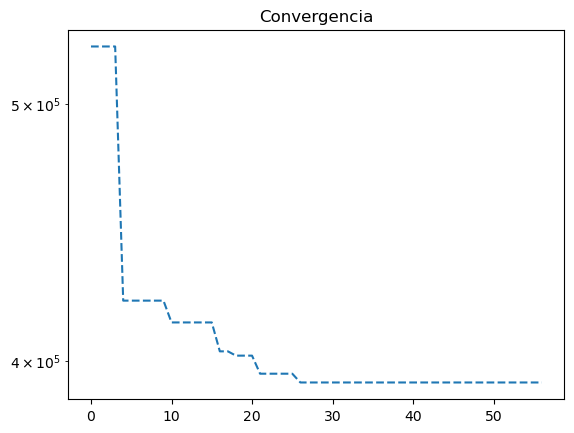

In [24]:
n_evals = np.array([e.evaluator.n_eval for e in ga.history])
opt = np.array([e.opt[0].F for e in ga.history])
gen_evals = np.arange(opt.shape[0])

plt.title('Convergencia')
plt.plot(gen_evals, opt, '--')
plt.yscale('log')
plt.show()

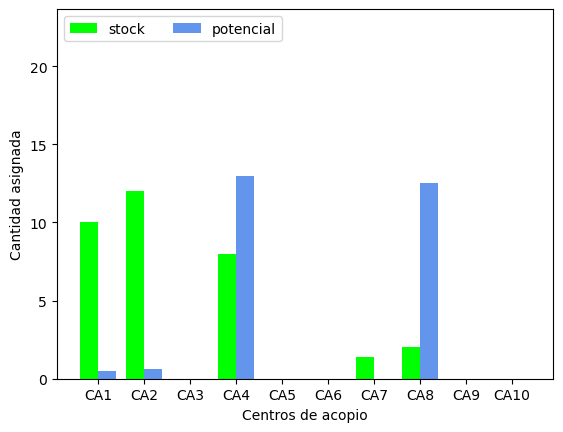

In [25]:
even = np.arange(0, N*2-1, 2)
odd = np.arange(1, N*2, 2)

cap_stock = np.take(CAPACIDADES, even)
cap_potencial = np.take(CAPACIDADES, odd)

ca_stock = np.take(ga.X, even)
ca_potencial = np.take(ga.X, odd)

labels = params_df['Id_CA']
x = np.arange(len(labels))
y1 = ca_stock
y2 = ca_potencial

fig, ax = plt.subplots()
y_lim = np.array(np.mean([np.max(CAPACIDADES), np.max(ga.X)])) * 1.1
ax.set_ylim([0, y_lim])
x1_bar = ax.bar(x-0.2, y1, width=0.4, label='stock', color='lime')
x2_bar = ax.bar(x+0.2, y2, width=0.4, label='potencial', color='cornflowerblue')

plt.xticks(x, labels)
plt.xlabel('Centros de acopio')
plt.ylabel('Cantidad asignada')
plt.legend(loc='upper left', ncol=2)
plt.show()

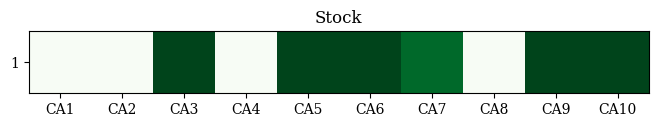

In [26]:
from pymoo.visualization.heatmap import Heatmap

ca_stock_norm = ca_stock / cap_stock
heatmap = Heatmap(bounds=(0, 1), 
                  title='Stock', 
                  cmap='Greens', 
                  labels=labels.values.tolist())
heatmap.add(ca_stock_norm)
heatmap.show()

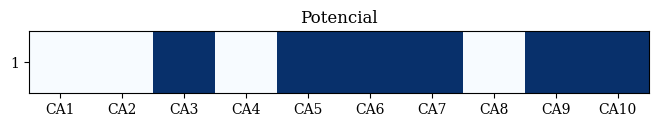

In [27]:
ca_potencial_norm = ca_potencial / cap_potencial
heatmap = Heatmap(bounds=(0, 1), 
                  title='Potencial', 
                  cmap='Blues', 
                  labels=labels.values.tolist())
heatmap.add(ca_potencial_norm)
heatmap.show()

testing https://pymoo.org/visualization/heatmap.html

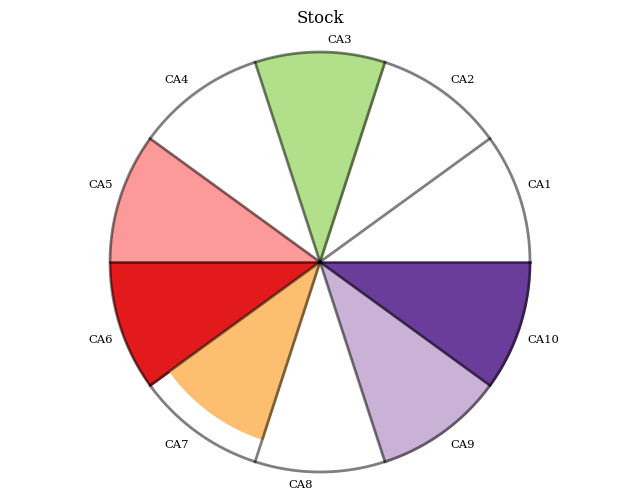

In [28]:
from pymoo.visualization.petal import Petal

petal = Petal(bounds=(0, 1), 
              cmap='Paired', 
              title='Stock',
              labels=labels.values.tolist(), 
              reverse=True)
petal.add(ca_stock_norm)
petal.show()

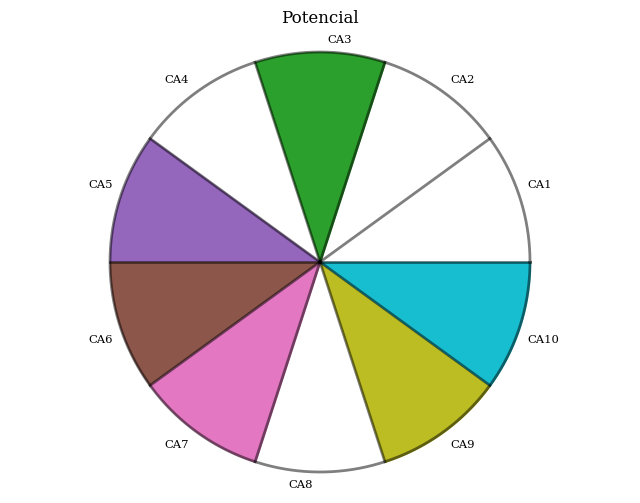

In [29]:
petal = Petal(bounds=(0, 1), 
              cmap='tab10',
              title='Potencial',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_potencial_norm)
petal.show()

# todo

Comenzar a buscar parámetros óptimos y documentar los resultados (La solución es óptima?) 

Hacer varias ejecuciones y medir estadísticos sobre los resultados obtenidos (varianza)